In [1]:
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import *
from scipy.ndimage import rotate
import plotly.express as px
from google.colab import files

#plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

# Cargar el archivo 'Erwin_Schrödinger_(1933).jpg'
uploaded = files.upload()

Saving Erwin_Schrödinger_(1933).jpg to Erwin_Schrödinger_(1933).jpg


# Transformada de Fourier bidimensional

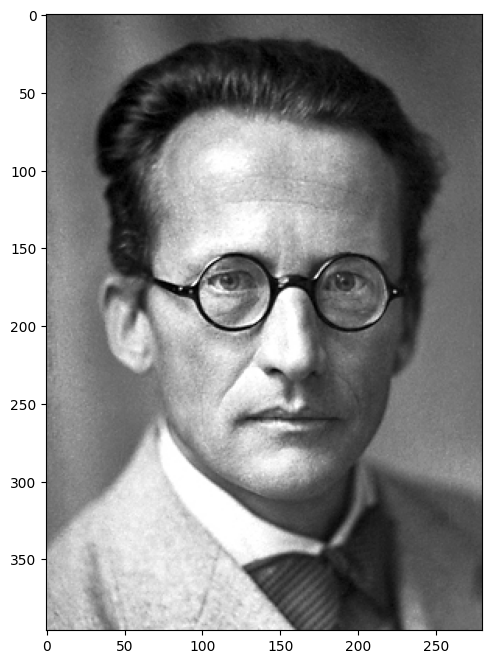

In [2]:
# Cargar el archivo 'Erwin_Schrödinger_(1933).jpg'
for i in uploaded.keys():
  filename=i
foto = imread(filename)
plt.imshow(foto)
plt.show()

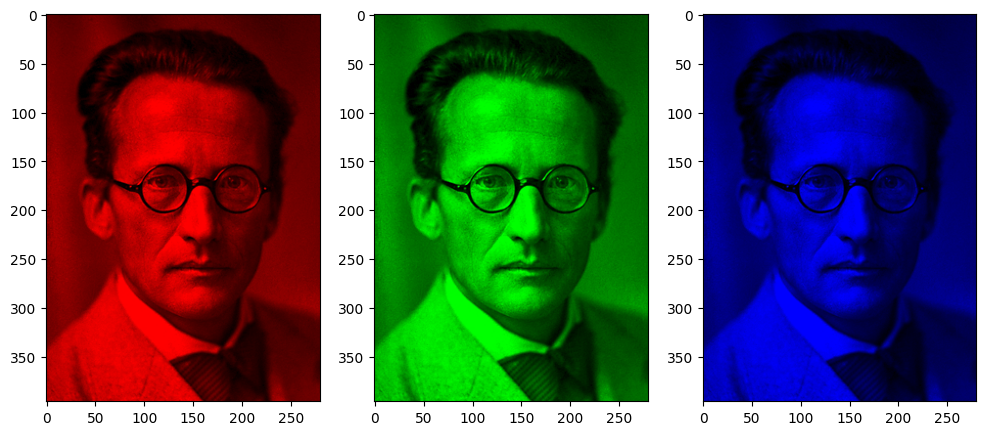

In [ ]:
# Observemos las diferentes componentes RGB de las cuales está compuesta una imagen
#La siguiente es otra forma de llamar cada componente de color. Recordar del ejemplo 'Ejemplo3_filtro_imagen_bmp' que 'foto' es un arreglo tri-dimensional donde la coordenada z es el color. Así por ejemplo foto[:,:,2] es la componente azul.

fig, ax = plt.subplots(nrows = 1, ncols=3)

for c, ax in zip(range(3), ax):

    split_img = np.zeros(foto.shape, dtype="uint8")

    split_img[ :, :, c] = foto[ :, :, c]

    ax.imshow(split_img)

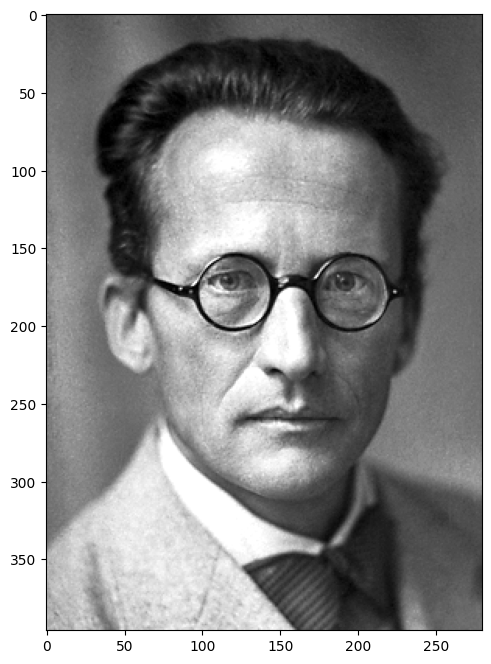

In [ ]:
#En lugar de hacer el promedio explícito punto a punto como en el ejemplo 'Ejemplo3_filtro_imagen_bmp', se puede de forma más corta usar np.mean(array,axis), donde axis=-1 quiere decir el último eje (en este caso el eje z que da el color)
foto_gris = np.mean(foto, -1) # Convertimos a escala de grises
plt.imshow(foto_gris, cmap = 'gray')
plt.show()

Encontremos la transformada de Fourier bidimensional, para ello podemos tomar inicialmente la transformada de Fourier en todas las filas y luego en las columnas.

<ipython-input-10-44d110f6fd33>:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(vertical)), cmap = 'gray', extent = [-x,x,-y,y]) # Extent corrige las dimensiones


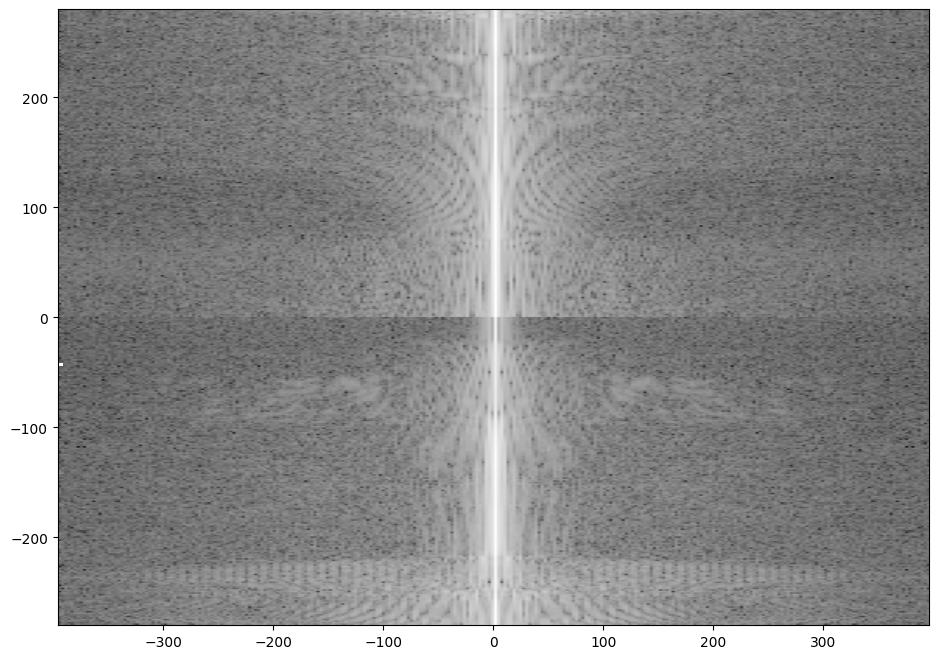

In [ ]:
#En este ejemplo se encuentra la transformada de Fourier usando scipy.fft
# FFT Vertical
x, y = foto_gris.shape # Dimensiones de la imagen
vert = np.zeros_like(foto_gris, dtype='complex') # Creamos un array para guardar los datos

for i in range(foto_gris.shape[0]):
    vert[i,:] = fft(foto_gris[i,:]) # Realizamos la FFT (1D) a lo largo de la dirección vertical

vertical = fftshift(vert) # FFTSHIFT es aplicado para que el máximo central este en la posición correcta
plt.imshow(np.log(abs(vertical)), cmap = 'gray', extent = [-x,x,-y,y]) # Extent corrige las dimensiones
plt.grid(False)

plt.show()

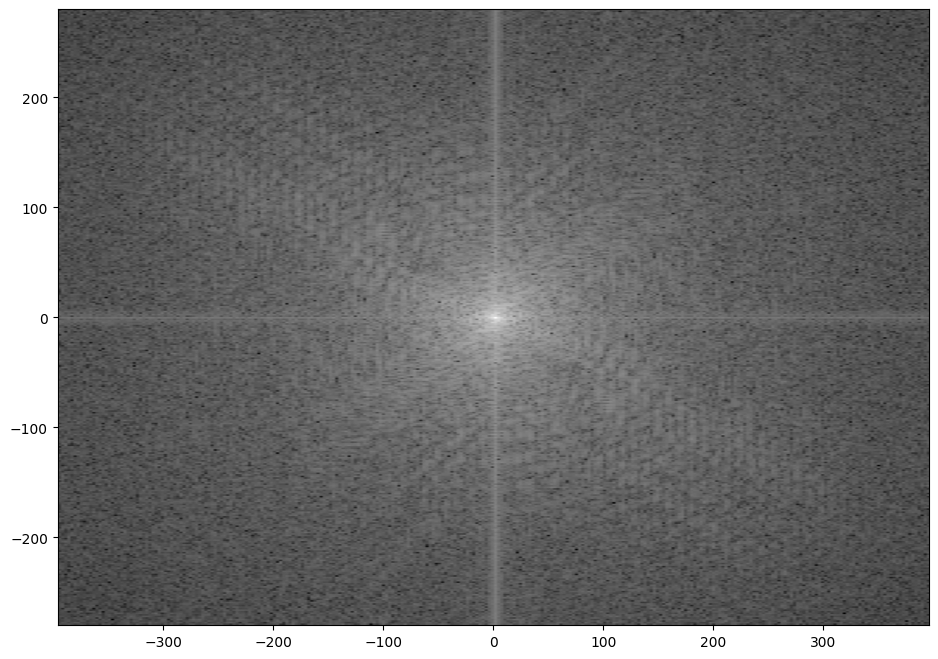

In [ ]:
# FFT horizontal de la vertical

hori = np.zeros_like(vert, dtype='complex')

for i in range(vert.shape[1]):
    hori[:,i] = fft(vert[:,i]) # FFT sobre la FFT vertical previamente realizada

horizontal = fftshift(hori) # Recordemos que debemos hacer el shift sobre la fft para ordenar las frecuencias

plt.imshow(np.log(abs(horizontal)), cmap = 'gray', extent = [-x,x,-y,y])
plt.grid(False)

plt.show()


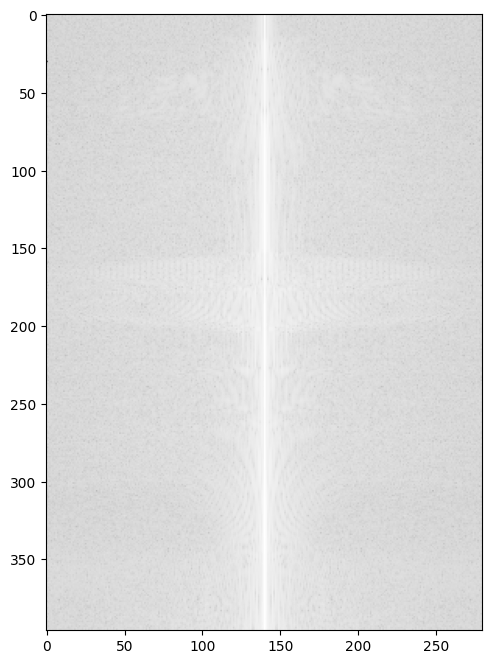

In [ ]:
# Transformada inversa

# Realizamos inicialmente en la componente horizontal
hori_inversa = np.zeros_like(horizontal, dtype='complex')

for i in range(horizontal.shape[1]):
    hori_inversa[:,i] = ifft(horizontal[:,i]) # FFT sobre la FFT vertical previamente realizada

plt.imshow(np.log(abs(hori_inversa)), cmap = 'gray')
plt.grid(False)
plt.show()

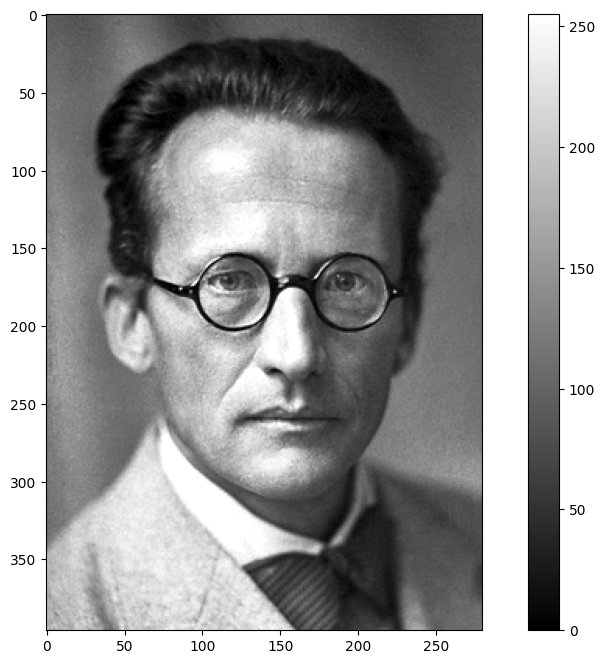

In [ ]:
# Ahora podemos hacer la ifft de la señal obtenida

foto_recuperada = ifft(hori_inversa)
plt.imshow(abs(foto_recuperada), cmap = 'gray')
plt.grid(False)
plt.colorbar() # La imagen está compuesta de una escala que va de 0 (negro) a blanco (255) 8-bits
plt.show()

Veamos ahora cómo se realiza usando simplemente la libreria `fft2`

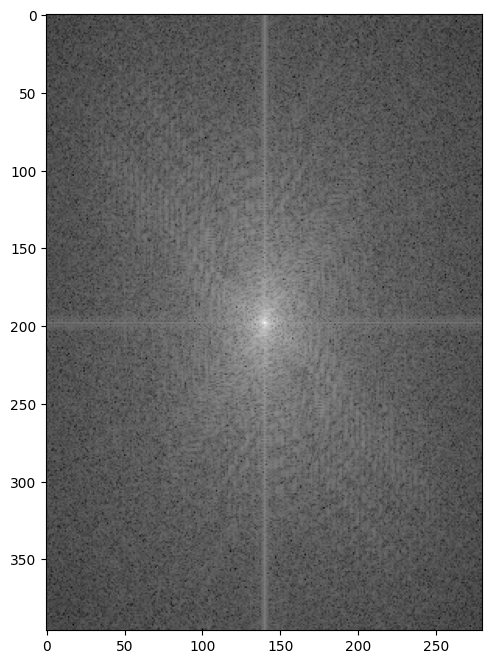

In [ ]:
fou2d = fft2(foto_gris)
fou2 = fftshift(fft2(foto_gris))
plt.imshow(np.log(abs(fou2)), cmap = 'gray')
plt.grid(False)
plt.show()

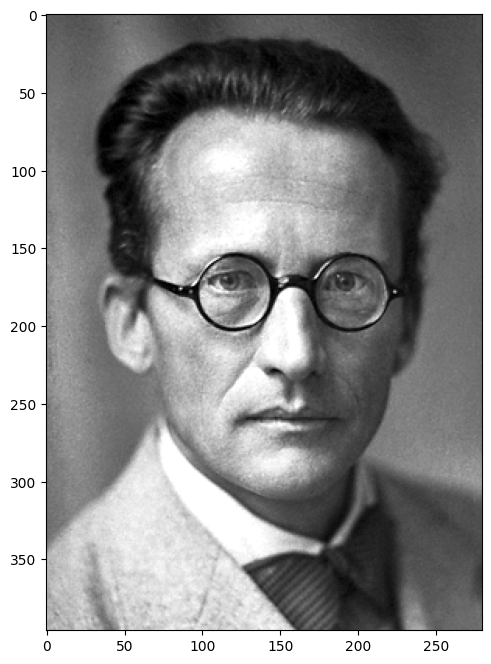

In [ ]:
# Recuperemos la imagen
plt.imshow(abs(ifft2(fou2d)), cmap = 'gray')
plt.grid(False)
plt.show()

## Compresión de imágenes

<ipython-input-17-b5a3f0a0ff78>:16: RuntimeWarning: divide by zero encountered in log
  plt.imshow(fftshift(np.log(abs(Atlow))), cmap = 'jet') # TF filtrada


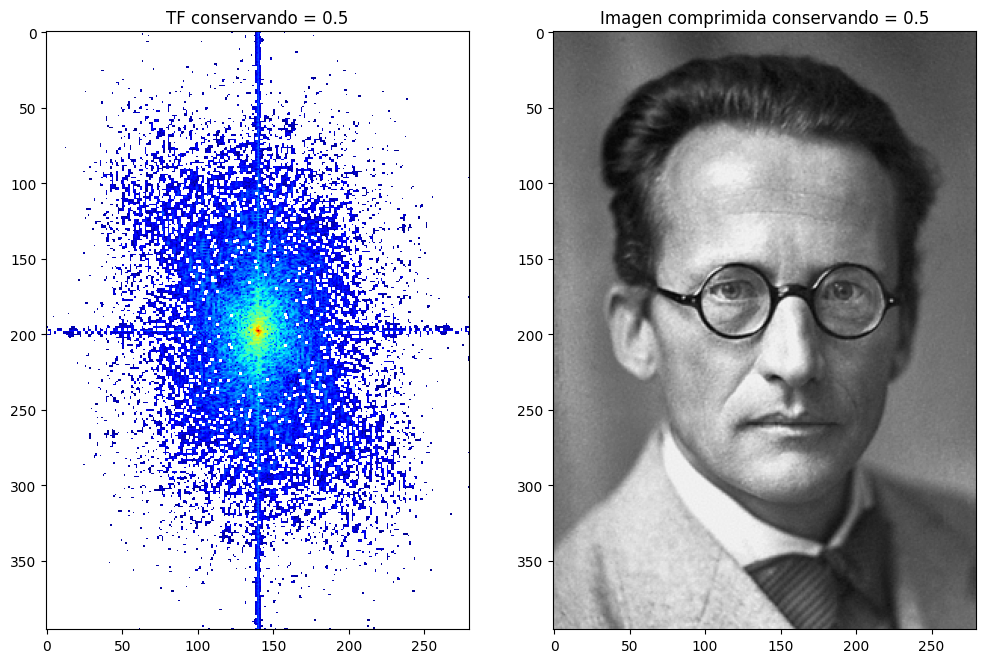

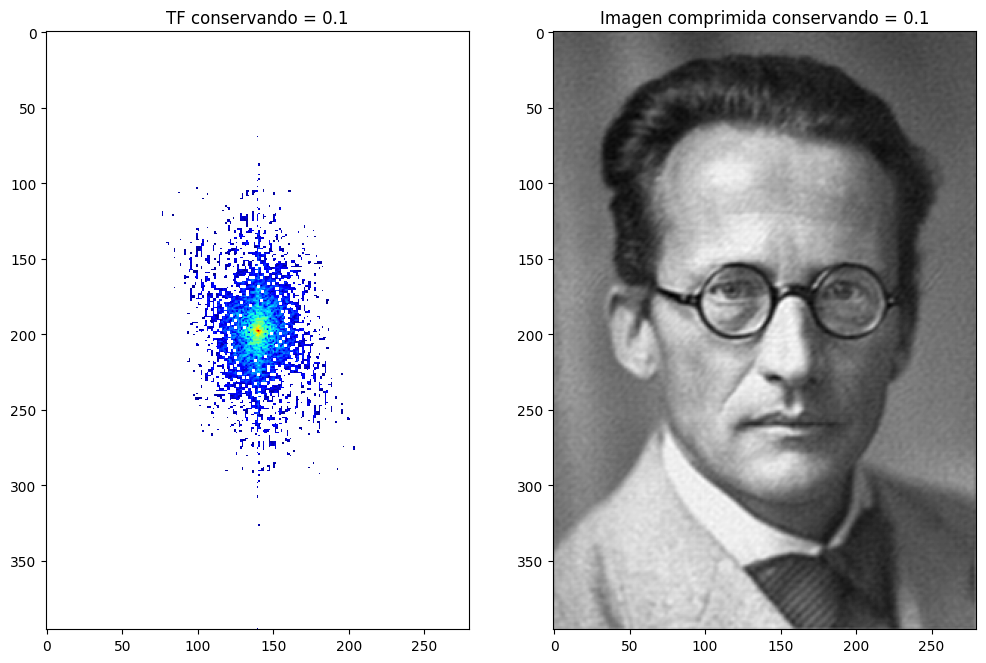

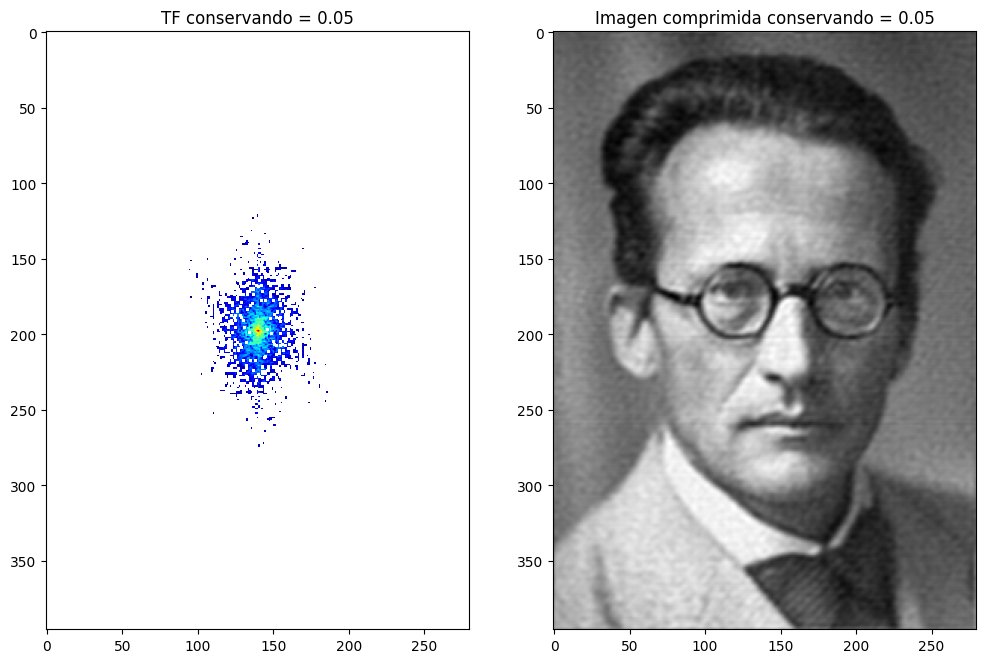

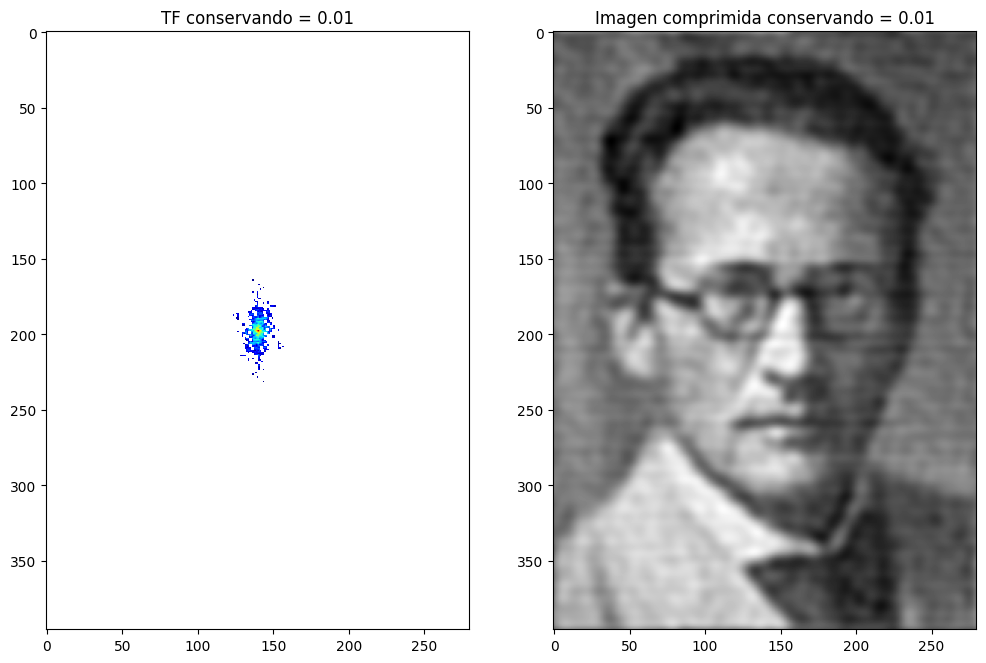

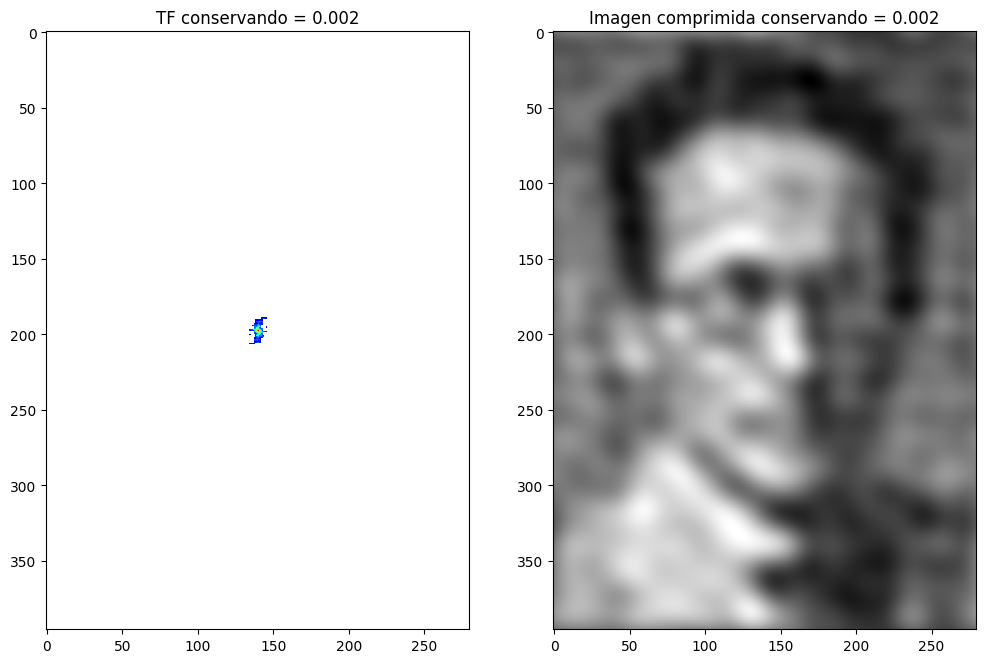

In [ ]:
A = imread(filename)

B = np.mean(A, -1); # Escala de grises

Bt = fft2(B)
Btsort = np.sort(np.abs(Bt.reshape(-1))) # reorganizando en terminos de la magnitud. (Cuando se hace numpy.reshape(-1), la forma (shape) se infiere de la longitud. np.sort() organiza el 'flattened' array por su magnitud)

# Cerando coeficientes pequeños y tomando la transformadada
for keep in (0.5, 0.1, 0.05, 0.01, 0.002):
    thresh = Btsort[int((1-keep)*len(Btsort))]
    ind = np.abs(Bt) > thresh          # Encuentra indices bajos (ind es un arreglo de la misma forma de Bt, pero hecho de 1's si se cumple la condición y 0's si no se cumple)
    Atlow = Bt * ind                 # Aplicando el limite inferior
    Alow = ifft2(Atlow).real  # Imagen comprimida
    plt.figure()
    plt.subplot(121)
    plt.imshow(fftshift(np.log(abs(Atlow))), cmap = 'jet') # TF filtrada
    plt.title('TF conservando = ' + str(keep))
    plt.subplot(122)
    plt.imshow(Alow, cmap = 'gray') # Imagen recuperada
    plt.grid(False)
    plt.title('Imagen comprimida conservando = ' + str(keep))
    plt.show()

# Filtrado espacial

In [ ]:
def grating(size, wavelength, theta):
    """Función para generar rejillas senosoidal con tamaño, longitud y ángulo variable
    Parametros:
    --------
    size : tamaño de la rejilla
    wavelenght: Longitud de onda
    Theta: ángulo en deg
    """
    x = np.arange(-size, size+1, 1)
    X, Y = np.meshgrid(x, x) #https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html
    angle = theta * np.pi / 180 # Ángulo de la rejilla
    rejilla = np.sin(2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / wavelength)
    return rejilla

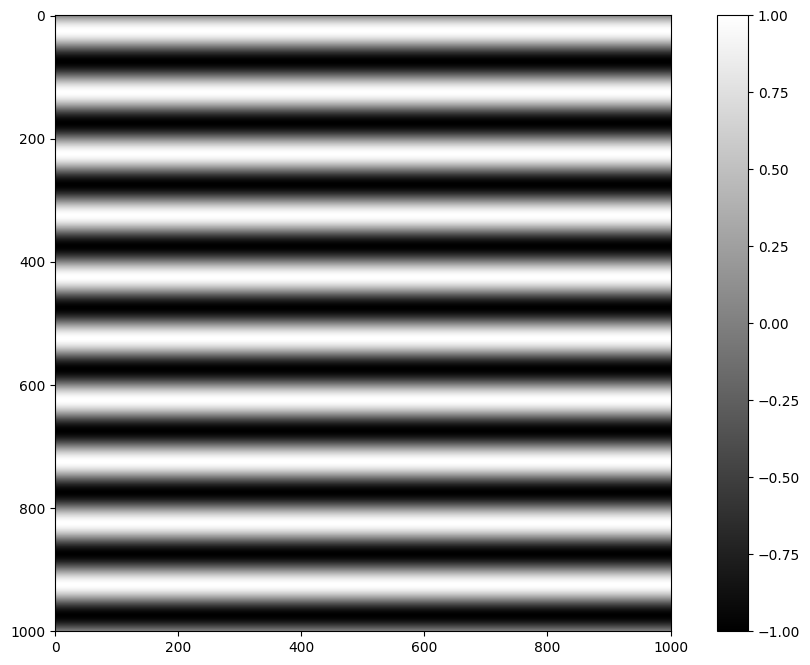

In [ ]:
# Generemos una rejilla (vertical, horizontal o con cierto angulo de ancho variable)
gvertical = grating(500,100,90) # Rejilla horizontal
plt.imshow(gvertical, cmap= 'gray')
plt.colorbar()
plt.show()

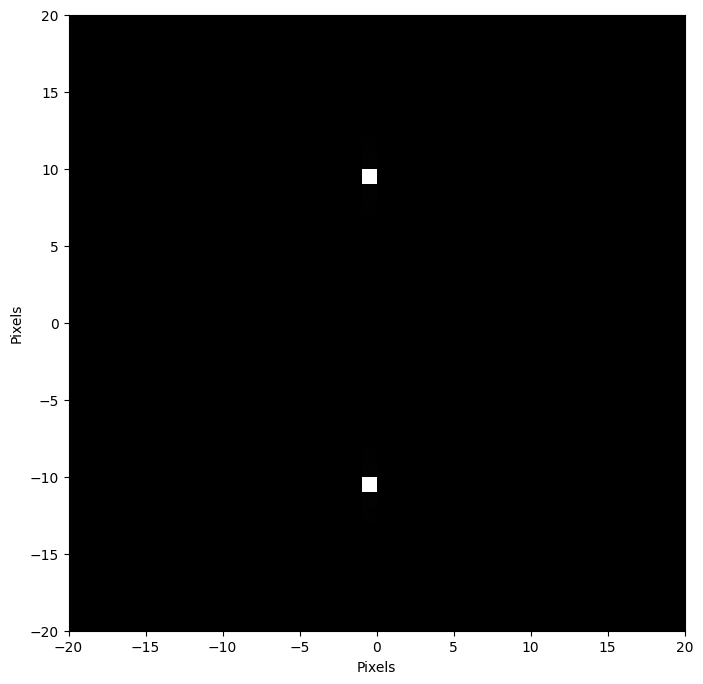

In [ ]:
# Vemos que mientras que la rejilla es horizontal su TF está verticalmente, ya que allí está la frecuencia de la señal
a, b = gvertical.shape
fg = fftshift(fft2(gvertical))
plt.imshow(abs(fg), cmap = 'gray', extent= [-a//2, a//2, -b//2, b//2]) # Extent: define unas nuevas coordenadas
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

Los dos puntos en la imagen anterior corresponden a las frecuencias de la señal (imagen). Recordemos que la transformada de Fourier es simétrica con respecto al cero (centro de la imagen).

## Transformada de Fourier y filtrado

Saving Imagen_una_frecuencia.tif to Imagen_una_frecuencia.tif


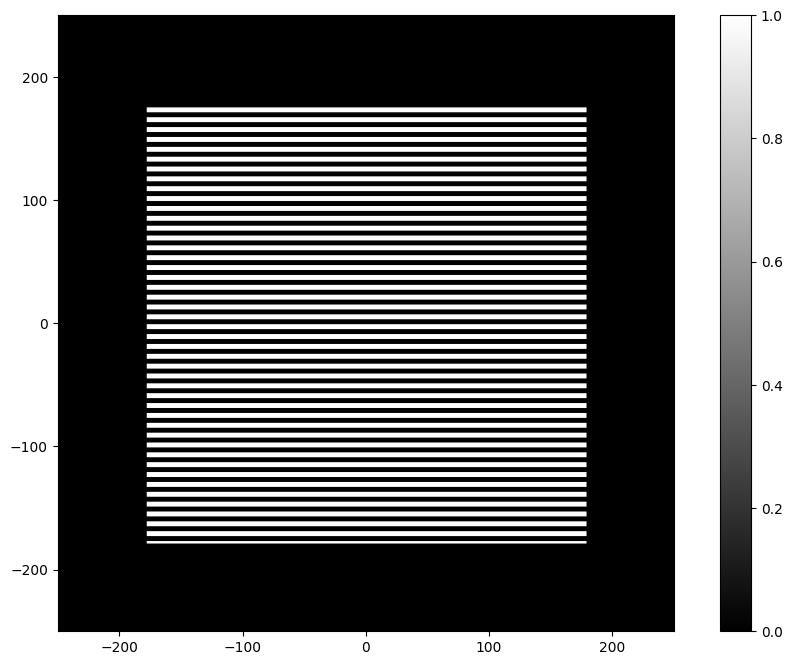

In [ ]:
uploaded = files.upload() #Cargar Imagen_una_frecuencia.tif
for i in uploaded.keys():
  filename=i
IM1 = imread(filename)

a, b = IM1.shape

# Normalizando las intensidades
IM1=IM1/np.max(IM1)
plt.imshow(IM1, extent=[-a//2,a//2,-b//2,b//2], cmap = 'gray')
plt.grid(False)
plt.xlim(-250,250)
plt.ylim(-250,250)
plt.colorbar()
plt.show()

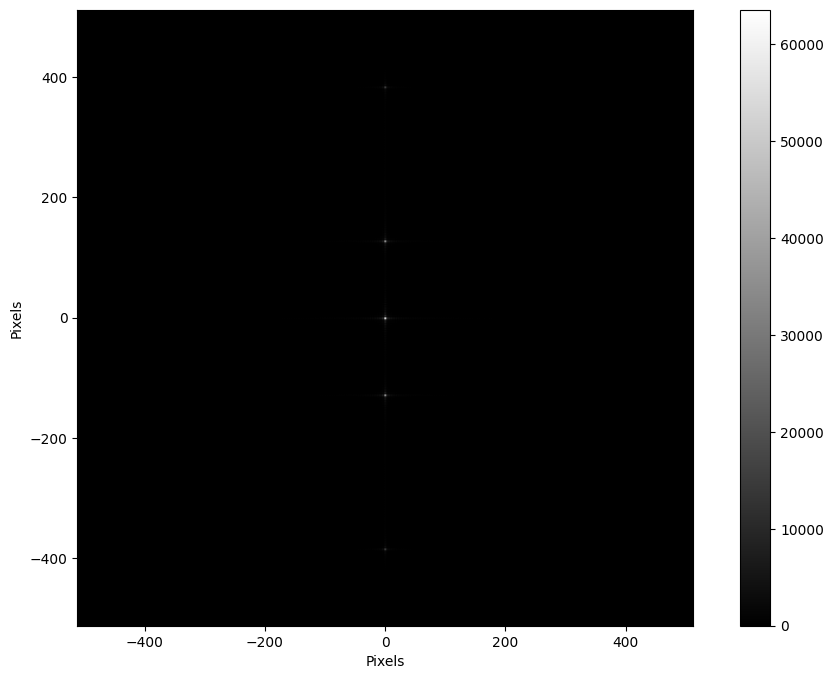

In [ ]:
# Tomemos la TF bidimensional de la imagen
TF_IM1 = fftshift(fft2(IM1))
a, b = IM1.shape
plt.imshow(abs(TF_IM1), cmap='gray', extent=[-a//2,a//2,-b//2,b//2])
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()
plt.grid(False)
plt.show()

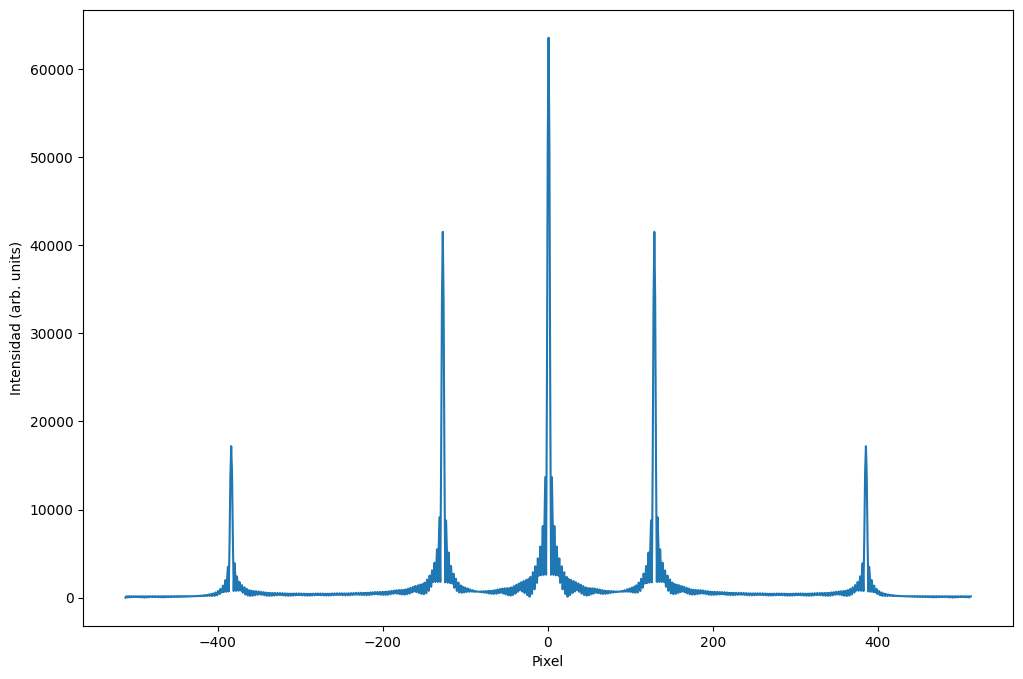

In [ ]:
px = np.linspace(-a//2, a//2+1, a) # Definamos nuestras coordenadas para centrar el espectro

plt.plot(px, abs(TF_IM1[:,b//2])) # Veamos un corte transversal, para ubicar las frecuencias
plt.xlabel('Pixel')
plt.ylabel('Intensidad (arb. units)')
#plt.xlim(400,600)
plt.show()

Consideremos los siguientes filtros definidos en el espacio de Fourier

In [ ]:
# Rendija por la cual filtrar la señal
def rendija(N,ang,esp):
  filt = np.zeros((N,N))
  filt[int(N/2+1-esp/2):int(N/2+1+esp/2),:] = 1
  return rotate(filt,ang,reshape=False)

In [ ]:
slitv = rendija(len(TF_IM1), 90, 50) # Rendija vertical
slith = rendija(len(TF_IM1), 0, 50) # Rendija horizontal
slit = slith * slitv # Formamos un cuadrado

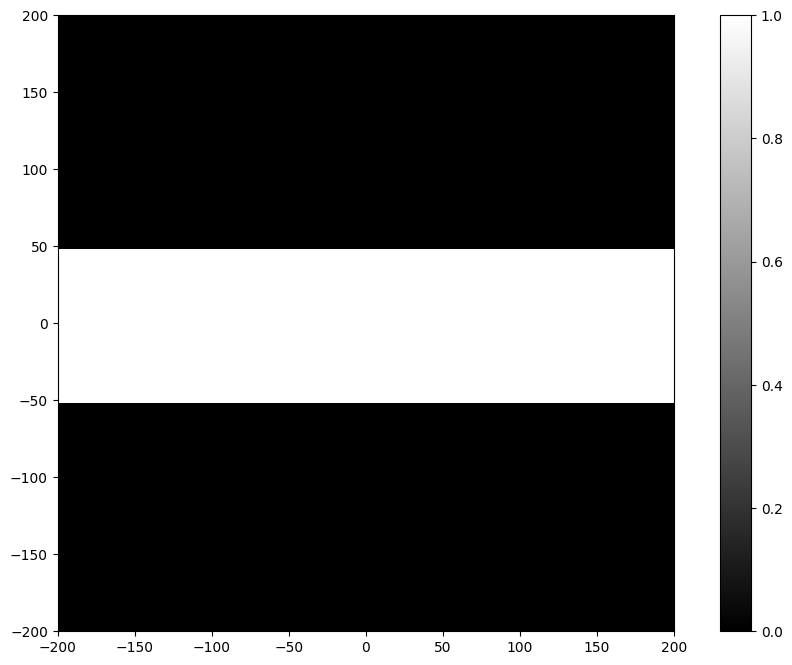

In [ ]:
plt.imshow(slith, extent=[-a,a,-b,b], cmap= 'gray') # Veamos la rendija horizontal
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.colorbar()
plt.grid(False)
plt.show()

Con el filtro anterior dejamos que solo la información que pase por la franja blanca quede en la señal resultante y el resto se hace cero.

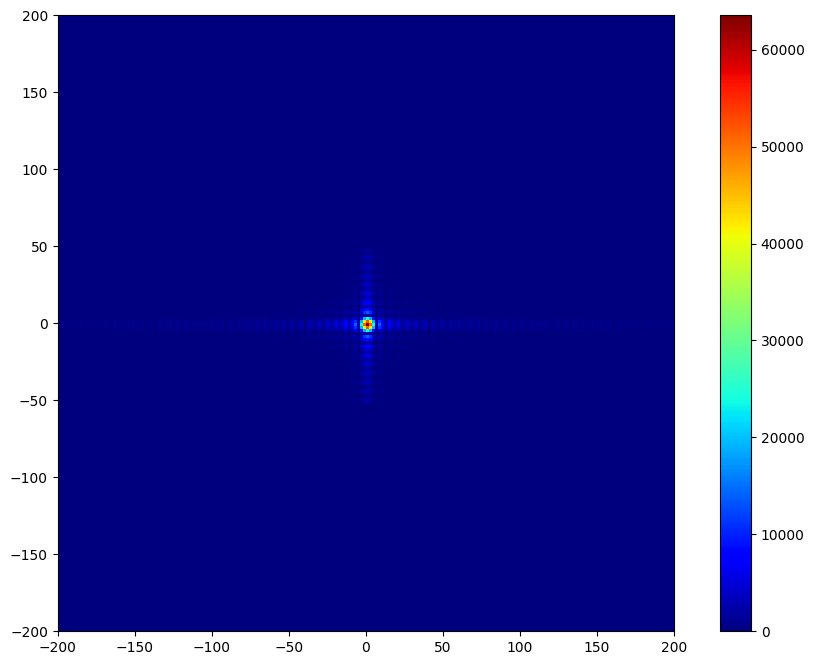

In [ ]:
# Ahora tomemos la TF de la imagen y hagamosla pasar por nuestro filtro
filtrada = slith * TF_IM1
plt.imshow(abs(filtrada), extent=[-a,a,-b,b], cmap= 'jet')
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.colorbar()
plt.grid(False)
plt.show()

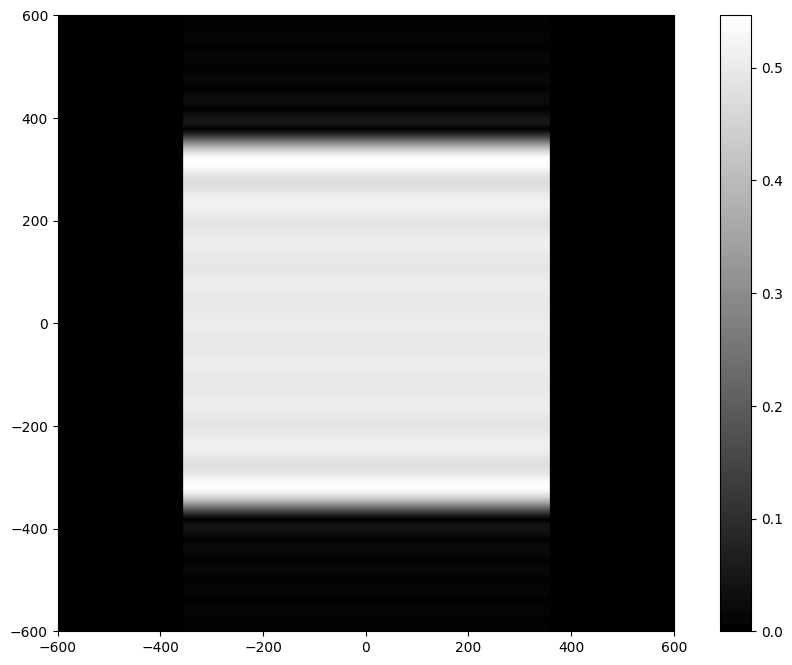

In [ ]:
fourier_filtrada = ifft2(filtrada) # Calculemos la transformada inversa de la imágen filtrada

plt.imshow(abs(fourier_filtrada), extent=[-a,a,-b,b], cmap = 'gray')
plt.xlim(-600,600)
plt.ylim(-600,600)
plt.colorbar()
plt.grid(False)
plt.show()

La imagen pierde calidad de resolución en las esquinas y también no es posible resolver los máximos y mínimos claramente. Pareciendo un simple cuadrado. Por ende, al ver un corte transversal, obtenemos que:

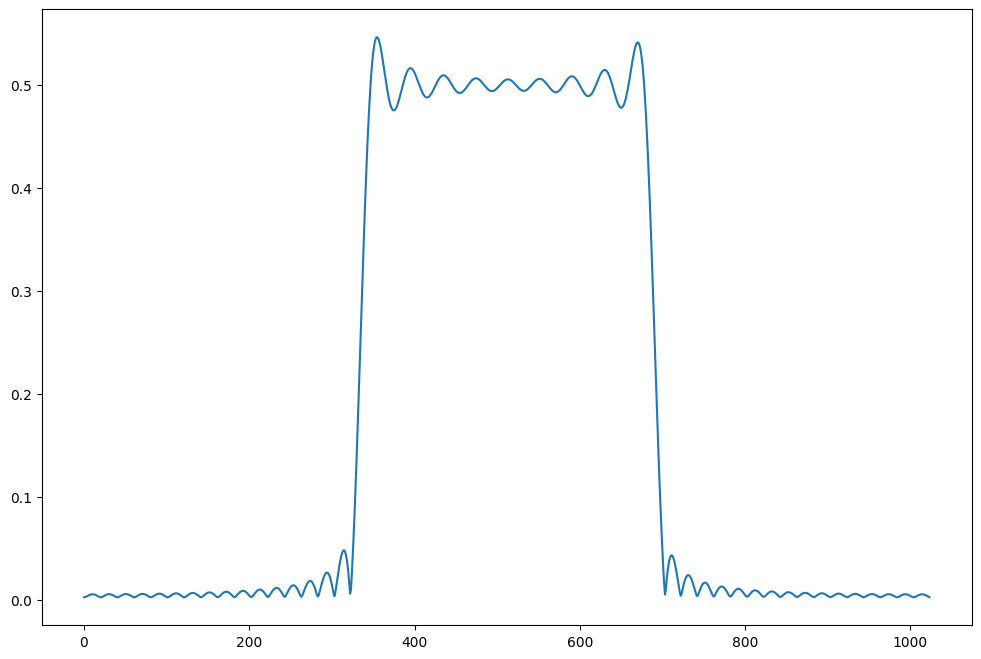

In [ ]:
plt.plot(abs(fourier_filtrada[:,a//2])) # Corte transversal
#plt.xlim(a//2, a//2+100)
plt.show()

### Filtrado en frecuencia

Saving Imagen_para_filtrado.tif to Imagen_para_filtrado.tif


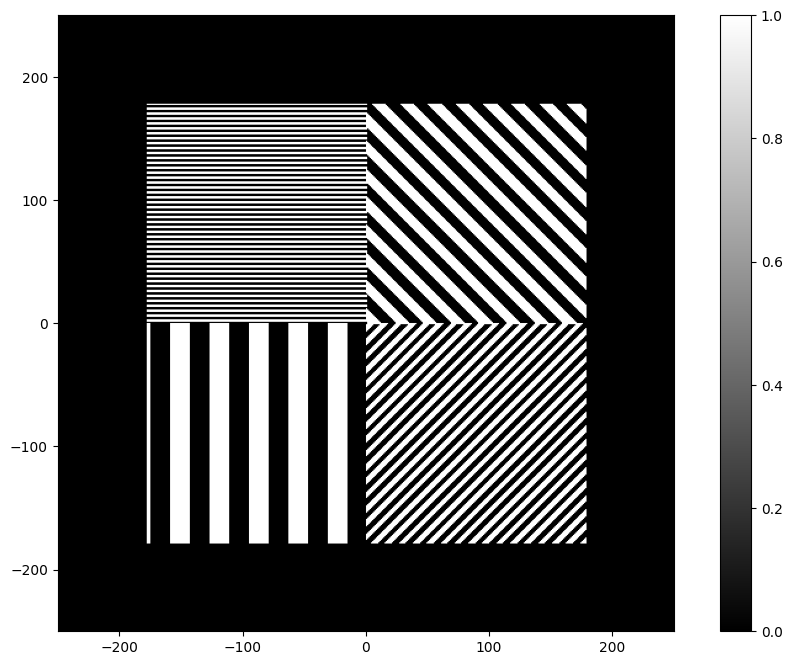

In [ ]:
uploaded = files.upload() #Cargar Imagen_para_filtrado.tif
for i in uploaded.keys():
  filename=i
IMF = imread(filename)

a, b = IMF.shape
# Normalizando las intensidades
IMF=IMF/np.max(IMF)
TF_IMF = fftshift(fft2(IMF)) # Transformada de Fourier
plt.imshow(IMF, extent=[-a//2,a//2,-b//2,b//2], cmap = 'gray')
plt.xlim(-250,250)
plt.ylim(-250,250)
plt.colorbar()
plt.grid(False)
plt.show()

La imagen anterior está compuesta por rejillas con diferentes orientaciones, frecuencias y longitudes de onda, por ende si aplicamos filtros como el que vimos en el ejemplo anterior, podríamos "esconder" cierta información que consideremos irrelevante.

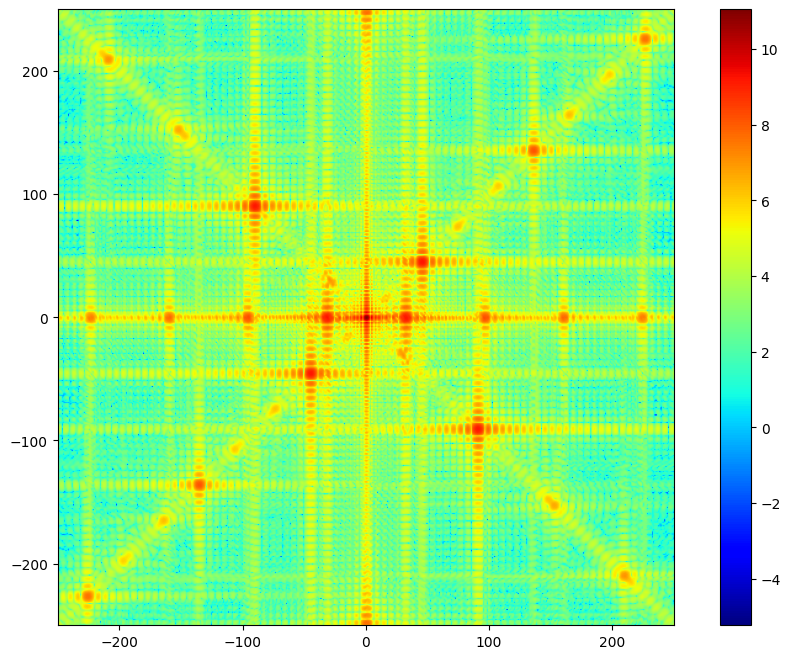

In [ ]:
# Transformada de Fourier imagen
plt.imshow(np.log(abs(TF_IMF)), extent=[-a//2,a//2,-b//2,b//2], cmap='jet')
plt.xlim(-250,250)
plt.ylim(-250,250)
plt.colorbar()
plt.grid(False)
plt.show()

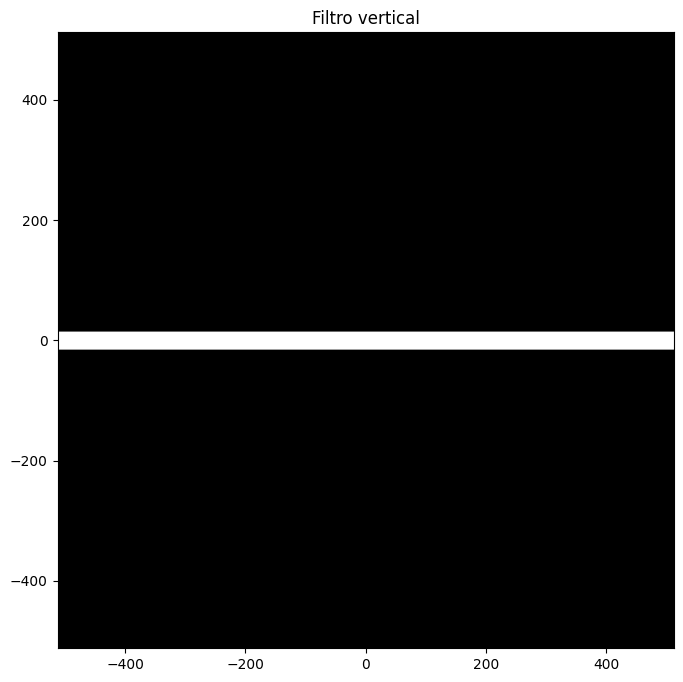

In [ ]:
# Rejilla de filtrado
slitv = rendija(len(TF_IMF), 0, 30) # Filtro con 0 grados
plt.title('Filtro vertical')
plt.imshow(abs(slitv), extent=[-a//2,a//2,-b//2,b//2], cmap='gray')
plt.show()

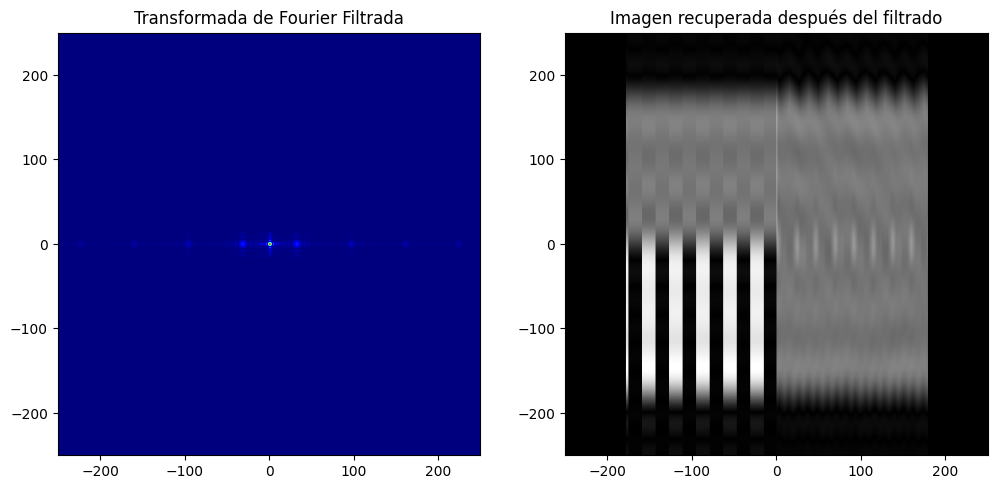

In [ ]:
filtrado_frec = slitv * TF_IMF # Aplicando el filtro a la TF
IMF_Filtrada = ifft2(filtrado_frec) # Recuperando la imagen filtrada

plt.subplot(121)
plt.title('Transformada de Fourier Filtrada')
plt.imshow(abs(filtrado_frec), extent=[-a//2,a//2,-b//2,b//2], cmap='jet')
plt.xlim(-250,250)
plt.ylim(-250,250)

plt.subplot(122)
plt.title('Imagen recuperada después del filtrado')
plt.imshow(abs(IMF_Filtrada), extent=[-a//2,a//2,-b//2,b//2], cmap = 'gray')
plt.xlim(-250,250)
plt.ylim(-250,250)
plt.show()


Apliquemos filtros para diferentes ángulos en la imagen original y veamos su resultado

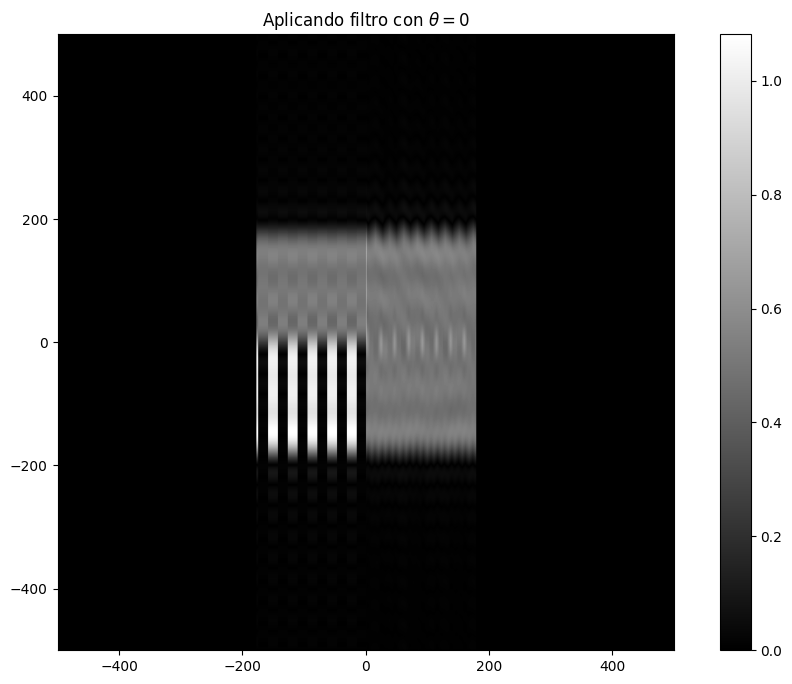

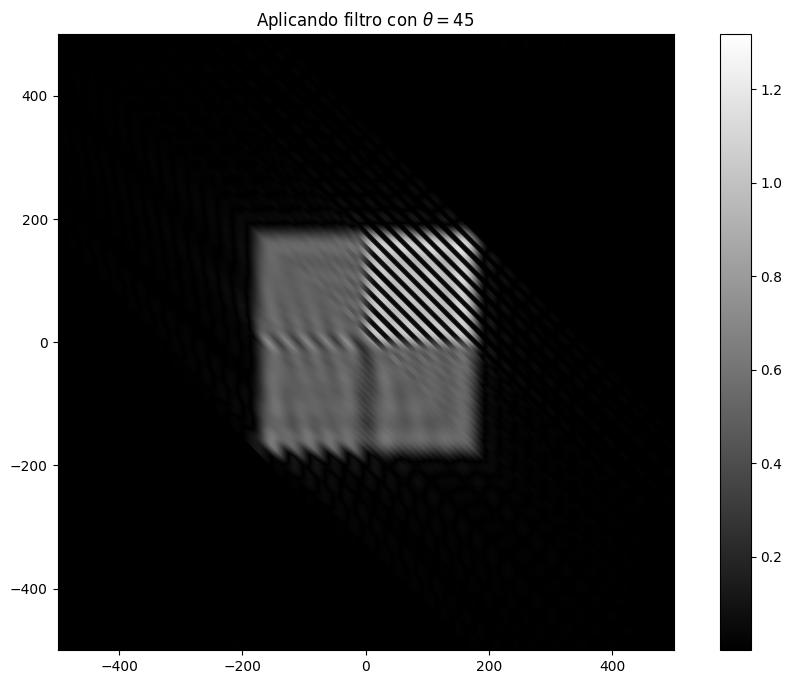

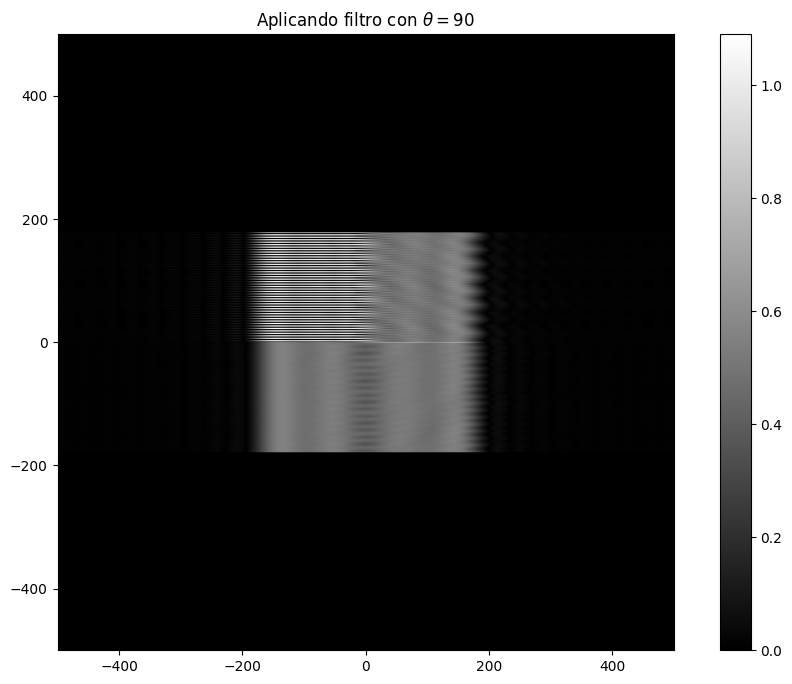

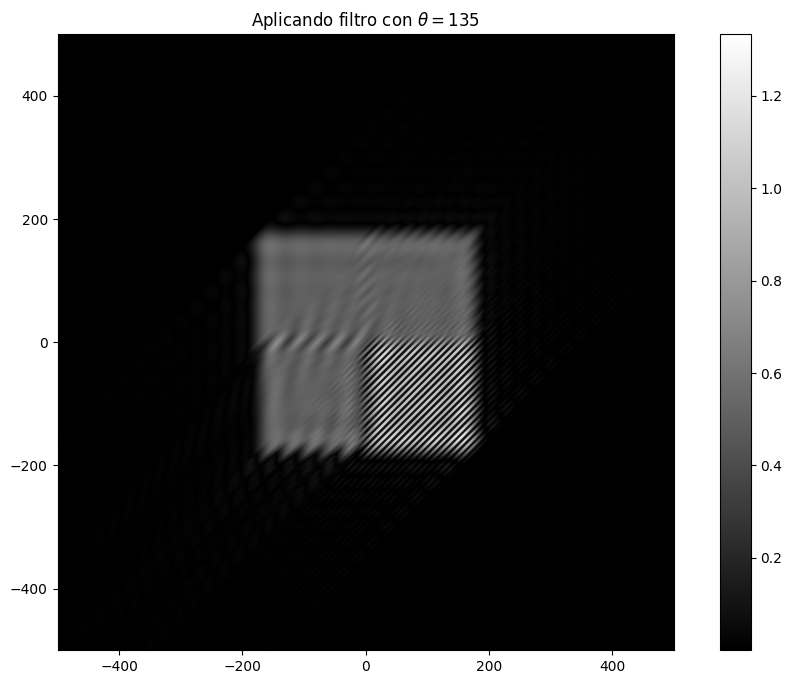

In [ ]:
for angulo in (0,45,90,135):
    slitv = rendija(len(TF_IMF), angulo, 30)
    filtrado_frec = slitv * TF_IMF # Aplicando el filtro a la TF
    IMF_Filtrada = ifft2(filtrado_frec) # Recuperando la imagen filtrada
    plt.imshow(abs(IMF_Filtrada), extent=[-a//2,a//2,-b//2,b//2], cmap = 'gray')
    plt.xlim(-500,500)
    plt.ylim(-500,500)
    plt.colorbar()
    plt.grid(False)
    titulo = r"Aplicando filtro con $\theta = $"
    plt.title(titulo + str(angulo))
    plt.show()


### Eliminando ruido


Esta parte se encuentra aun en desarrollo

In [ ]:
foto_ruido = foto_gris + 50*np.random.randn(*foto_gris.shape)

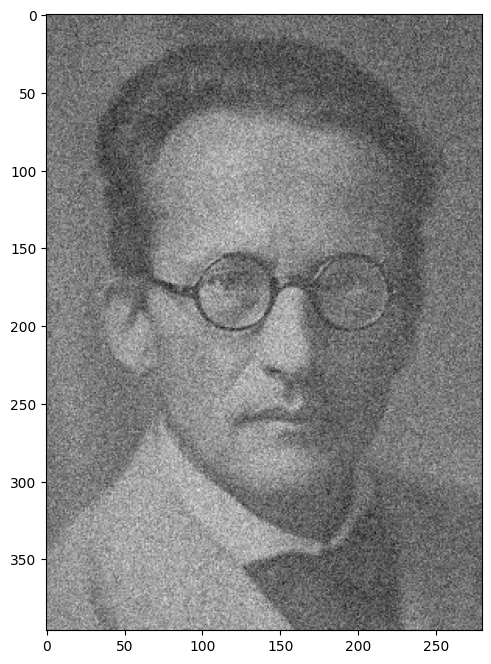

In [ ]:
plt.imshow(foto_ruido, cmap='gray')
plt.show()

In [ ]:
Fourier_ruido = np.fft.fft2(foto_ruido)
Fourier_ruido_shift = np.fft.fftshift(Fourier_ruido)

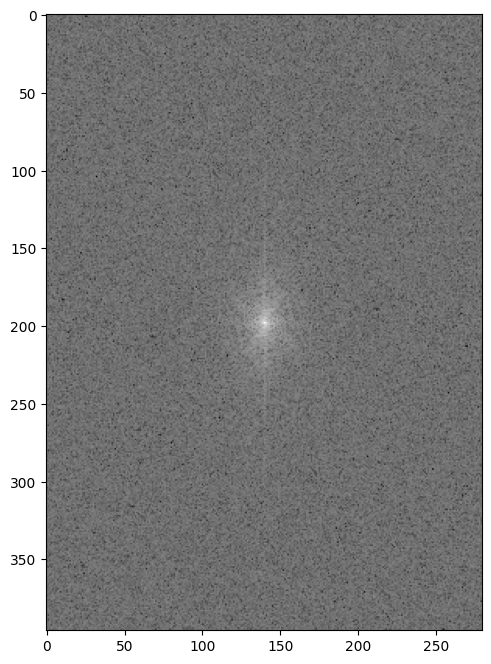

In [ ]:
plt.imshow(np.log(abs(Fourier_ruido_shift)), cmap = 'gray')
plt.show()

In [ ]:
nx,ny = foto_ruido.shape
X,Y = np.meshgrid(np.arange(-ny/2+1,ny/2+1),np.arange(-nx/2+1,nx/2+1))
R2 = np.power(X,2) + np.power(Y,2)  # Rejilla circular

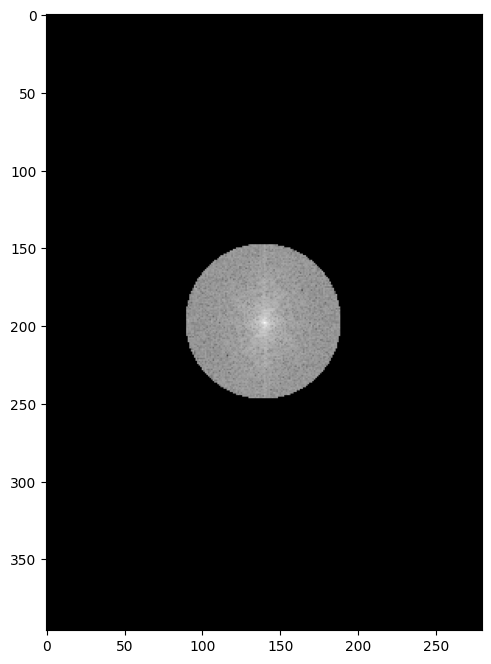

In [ ]:
ind = R2 < 50**2
filtrada_ruido = Fourier_ruido_shift * ind

Ffilt = np.log(np.abs(filtrada_ruido)+1) # Put FFT on log scale

plt.imshow(Ffilt,cmap='gray')
plt.show()

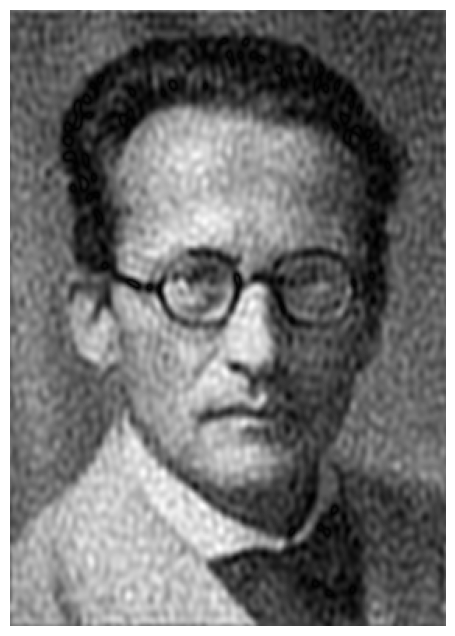

In [ ]:
Bfilt = ifft2(filtrada_ruido)
plt.imshow(abs(Bfilt),cmap='gray')
plt.axis('off')

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=16e1ed3d-c0b3-42a4-88c6-d9e65cd03f20' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>